In [2]:
from pymavlink import mavutil

import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

In [50]:
vehiculo = 'DA03'

In [51]:
path_rec = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\RECORRIDOS.shp'
gdf_rec = gpd.read_file(path_rec)

In [52]:
if vehiculo == 'DA01':
    path_log = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\TLOGS\ALTA_03'
contenido = os.listdir(path_log)
len(contenido)

9

In [53]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

9

In [54]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [55]:
lineas, names = leer_logs(contenido_filtrado)

In [56]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")

In [57]:
gdf_lines

,nombre,geometry
0,2024-08-20 20-47-04.tlog,"LINESTRING (-63.21555 -17.28824, -63.21555 -17..."
1,2024-08-20 21-49-22.tlog,"LINESTRING (-63.22210 -17.28097, -63.22210 -17..."
2,2024-08-20 22-53-52.tlog,"LINESTRING (-63.26321 -17.28706, -63.26321 -17..."
3,2024-08-22 04-36-52.tlog,"LINESTRING (-63.26322 -17.28706, -63.26322 -17..."
4,2024-08-22 19-09-59.tlog,"LINESTRING (-63.21068 -17.21585, -63.21068 -17..."
5,2024-08-23 17-11-59.tlog,"LINESTRING (-63.05443 -17.29934, -63.05443 -17..."
6,2024-08-23 18-04-18.tlog,"LINESTRING (-63.25377 -17.21192, -63.25377 -17..."
7,2024-08-23 19-52-23.tlog,"LINESTRING (-63.25443 -17.21623, -63.25443 -17..."
8,2024-08-23 21-09-39.tlog,"LINESTRING (-63.25385 -17.22072, -63.25385 -17..."


<Axes: >

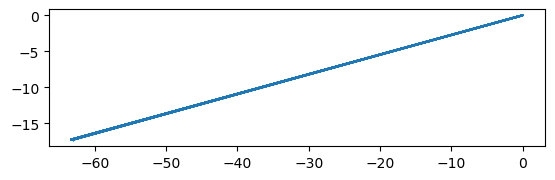

In [58]:
gdf_lines.plot()

In [59]:
# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [60]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [61]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [62]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

In [63]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)

In [64]:
gdf_lines['vehiculo'] = vehiculo

In [65]:
gdf_lines

,nombre,geometry,num_vert,vehiculo
0,2024-08-20 20-47-04.tlog,"LINESTRING (-63.21555 -17.28824, -63.21555 -17...",1072,DA03
1,2024-08-20 20-47-04.tlog,"LINESTRING (-63.21556 -17.28824, -63.21556 -17...",3301,DA03
2,2024-08-20 20-47-04.tlog,"LINESTRING (-63.21556 -17.28823, -63.21556 -17...",1540,DA03
3,2024-08-20 21-49-22.tlog,"LINESTRING (-63.22210 -17.28097, -63.22210 -17...",2748,DA03
4,2024-08-20 22-53-52.tlog,"LINESTRING (-63.26321 -17.28706, -63.26321 -17...",1999,DA03
5,2024-08-20 22-53-52.tlog,"LINESTRING (-63.26322 -17.28707, -63.26322 -17...",15,DA03
6,2024-08-22 04-36-52.tlog,"LINESTRING (-63.26322 -17.28706, -63.26322 -17...",1569,DA03
7,2024-08-22 19-09-59.tlog,"LINESTRING (-63.21068 -17.21585, -63.21068 -17...",1183,DA03
8,2024-08-22 19-09-59.tlog,"LINESTRING (-63.21067 -17.21586, -63.21067 -17...",2727,DA03
9,2024-08-22 19-09-59.tlog,"LINESTRING (-63.21068 -17.21585, -63.21068 -17...",1617,DA03


<Axes: >

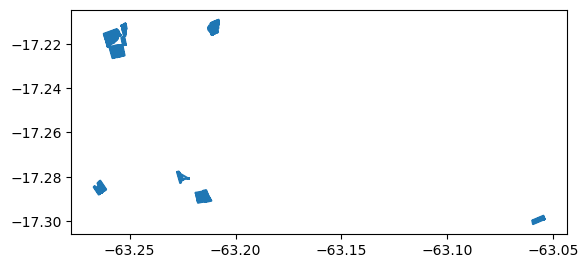

In [66]:
gdf_lines.plot()

In [67]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

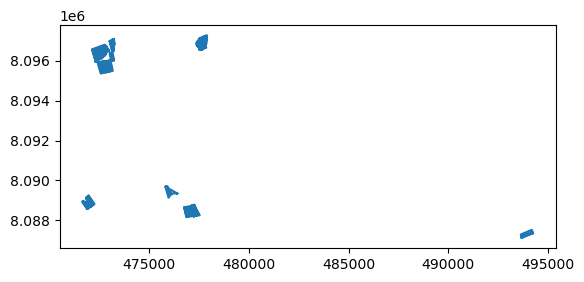

In [68]:
gdf_lines_utm.plot()

In [69]:
# Combinar los GeoDataFrames
gdf_combined = gpd.GeoDataFrame(pd.concat([gdf_rec, gdf_lines_utm], ignore_index=True))
# rellenar valores NaN
gdf_combined['idd'] = gdf_combined['idd'].fillna(0).astype(int)

In [70]:
gdf_combined

,idd,nombre,vehiculo,num_vert,id,asignado,geometry
0,0,Jul-20th-2024-08-43PM-Flight-Airdata.kml,DA03,807,1.0,si,"LINESTRING (460257.759 8096126.683, 460257.759..."
1,63,Jul-25th-2024-05-47PM-Flight-Airdata.kml,DA03,931,2.0,si,"LINESTRING (456011.255 8084542.548, 456011.265..."
2,63,Jul-25th-2024-06-51PM-Flight-Airdata.kml,DA03,1168,3.0,None,"LINESTRING (455648.848 8084842.307, 455648.848..."
3,63,Jul-25th-2024-07-06PM-Flight-Airdata.kml,DA03,1581,4.0,None,"LINESTRING (455647.763 8084843.024, 455647.752..."
4,0,Jul-25th-2024-10-42PM-Flight-Airdata.kml,DA03,1225,5.0,None,"LINESTRING (460855.506 8095707.381, 460855.527..."
...,...,...,...,...,...,...,...
612,0,2024-08-23 19-52-23.tlog,DA03,1225,NaN,NaN,"LINESTRING (472944.825 8096522.306, 472944.771..."
613,0,2024-08-23 19-52-23.tlog,DA03,2629,NaN,NaN,"LINESTRING (472945.388 8096522.129, 472945.324..."
614,0,2024-08-23 21-09-39.tlog,DA03,3894,NaN,NaN,"LINESTRING (473011.608 8096009.730, 473011.608..."
615,0,2024-08-23 21-09-39.tlog,DA03,2289,NaN,NaN,"LINESTRING (473012.702 8096010.285, 473012.702..."


In [71]:
gdf_combined.dtypes

idd            int32
nombre        object
vehiculo      object
num_vert       int64
id           float64
asignado      object
geometry    geometry
dtype: object

In [72]:
gdf_combined.to_file(path_rec, driver="ESRI Shapefile")